<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary', 'discharges_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,discharges_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,0,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,0,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...,...
2020-09-25 17:00:00+09:00,559,1714,195,0,2020-09-25 17:00:00+09:00
2020-09-26 17:00:00+09:00,613,1201,270,0,2020-09-26 17:00:00+09:00
2020-09-27 17:00:00+09:00,488,1153,144,0,2020-09-27 17:00:00+09:00
2020-09-28 17:00:00+09:00,608,2141,78,0,2020-09-28 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum
2020-09-25 17:00:00+09:00,559,1714,195,0,2020-09-25 17:00:00+09:00,612.857143,4290.0,1547.571429,10833.0,145.000000,1015.0,0.0,0.0
2020-09-26 17:00:00+09:00,613,1201,270,0,2020-09-26 17:00:00+09:00,613.428571,4294.0,1535.857143,10751.0,152.428571,1067.0,0.0,0.0
2020-09-27 17:00:00+09:00,488,1153,144,0,2020-09-27 17:00:00+09:00,592.571429,4148.0,1512.571429,10588.0,149.857143,1049.0,0.0,0.0
2020-09-28 17:00:00+09:00,608,2141,78,0,2020-09-28 17:00:00+09:00,583.857143,4087.0,1636.714286,11457.0,147.000000,1029.0,0.0,0.0
2020-09-29 17:00:00+09:00,0,0,212,0,2020-09-29 17:00:00+09:00,484.571429,3392.0,1463.142857,10242.0,164.714286,1153.0,0.0,0.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day
2020-09-15 17:00:00+09:00,528,1788,191,0,2020-09-15 17:00:00+09:00,633.571429,4435.0,1767.000000,12369.0,179.285714,1255.0,0.0,0.0,'20w38,Tue
2020-09-16 17:00:00+09:00,511,1775,163,0,2020-09-16 17:00:00+09:00,620.142857,4341.0,1769.000000,12383.0,181.285714,1269.0,0.0,0.0,'20w38,Wed
2020-09-17 17:00:00+09:00,533,1784,171,0,2020-09-17 17:00:00+09:00,610.428571,4273.0,1770.857143,12396.0,166.285714,1164.0,0.0,0.0,'20w38,Thu
2020-09-18 17:00:00+09:00,558,1845,220,0,2020-09-18 17:00:00+09:00,603.857143,4227.0,1750.571429,12254.0,171.000000,1197.0,0.0,0.0,'20w38,Fri
2020-09-19 17:00:00+09:00,609,1283,218,0,2020-09-19 17:00:00+09:00,573.142857,4012.0,1725.571429,12079.0,169.857143,1189.0,0.0,0.0,'20w38,Sat
2020-09-20 17:00:00+09:00,634,1316,162,0,2020-09-20 17:00:00+09:00,580.142857,4061.0,1728.285714,12098.0,172.142857,1205.0,0.0,0.0,'20w38,Sun
2020-09-21 17:00:00+09:00,669,1272,98,0,2020-09-21 17:00:00+09:00,577.428571,4042.0,1580.428571,11063.0,174.714286,1223.0,0.0,0.0,'20w39,Mon
2020-09-22 17:00:00+09:00,695,1215,88,0,2020-09-22 17:00:00+09:00,601.285714,4209.0,1498.571429,10490.0,160.000000,1120.0,0.0,0.0,'20w39,Tue
2020-09-23 17:00:00+09:00,580,2495,59,0,2020-09-23 17:00:00+09:00,611.142857,4278.0,1601.428571,11210.0,145.142857,1016.0,0.0,0.0,'20w39,Wed
2020-09-24 17:00:00+09:00,544,1538,195,0,2020-09-24 17:00:00+09:00,612.714286,4289.0,1566.285714,10964.0,148.571429,1040.0,0.0,0.0,'20w39,Thu


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-09-06 17:00:00+09:00,150.714286,1055
2020-09-13 17:00:00+09:00,175.857143,1231
2020-09-20 17:00:00+09:00,172.142857,1205
2020-09-27 17:00:00+09:00,149.857143,1049
2020-09-29 17:00:00+09:00,145.000000,290


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-09-15 17:00:00+09:00,528,1788,191,0,2020-09-15 17:00:00+09:00,633.571429,4435.0,1767.000000,12369.0,179.285714,1255.0,0.0,0.0,'20w38,Tue,NaN,NaN
2020-09-16 17:00:00+09:00,511,1775,163,0,2020-09-16 17:00:00+09:00,620.142857,4341.0,1769.000000,12383.0,181.285714,1269.0,0.0,0.0,'20w38,Wed,NaN,NaN
2020-09-17 17:00:00+09:00,533,1784,171,0,2020-09-17 17:00:00+09:00,610.428571,4273.0,1770.857143,12396.0,166.285714,1164.0,0.0,0.0,'20w38,Thu,NaN,NaN
2020-09-18 17:00:00+09:00,558,1845,220,0,2020-09-18 17:00:00+09:00,603.857143,4227.0,1750.571429,12254.0,171.000000,1197.0,0.0,0.0,'20w38,Fri,NaN,NaN
2020-09-19 17:00:00+09:00,609,1283,218,0,2020-09-19 17:00:00+09:00,573.142857,4012.0,1725.571429,12079.0,169.857143,1189.0,0.0,0.0,'20w38,Sat,NaN,NaN
2020-09-20 17:00:00+09:00,634,1316,162,0,2020-09-20 17:00:00+09:00,580.142857,4061.0,1728.285714,12098.0,172.142857,1205.0,0.0,0.0,'20w38,Sun,172.142857,1205.0
2020-09-21 17:00:00+09:00,669,1272,98,0,2020-09-21 17:00:00+09:00,577.428571,4042.0,1580.428571,11063.0,174.714286,1223.0,0.0,0.0,'20w39,Mon,NaN,NaN
2020-09-22 17:00:00+09:00,695,1215,88,0,2020-09-22 17:00:00+09:00,601.285714,4209.0,1498.571429,10490.0,160.000000,1120.0,0.0,0.0,'20w39,Tue,NaN,NaN
2020-09-23 17:00:00+09:00,580,2495,59,0,2020-09-23 17:00:00+09:00,611.142857,4278.0,1601.428571,11210.0,145.142857,1016.0,0.0,0.0,'20w39,Wed,NaN,NaN
2020-09-24 17:00:00+09:00,544,1538,195,0,2020-09-24 17:00:00+09:00,612.714286,4289.0,1566.285714,10964.0,148.571429,1040.0,0.0,0.0,'20w39,Thu,NaN,NaN


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

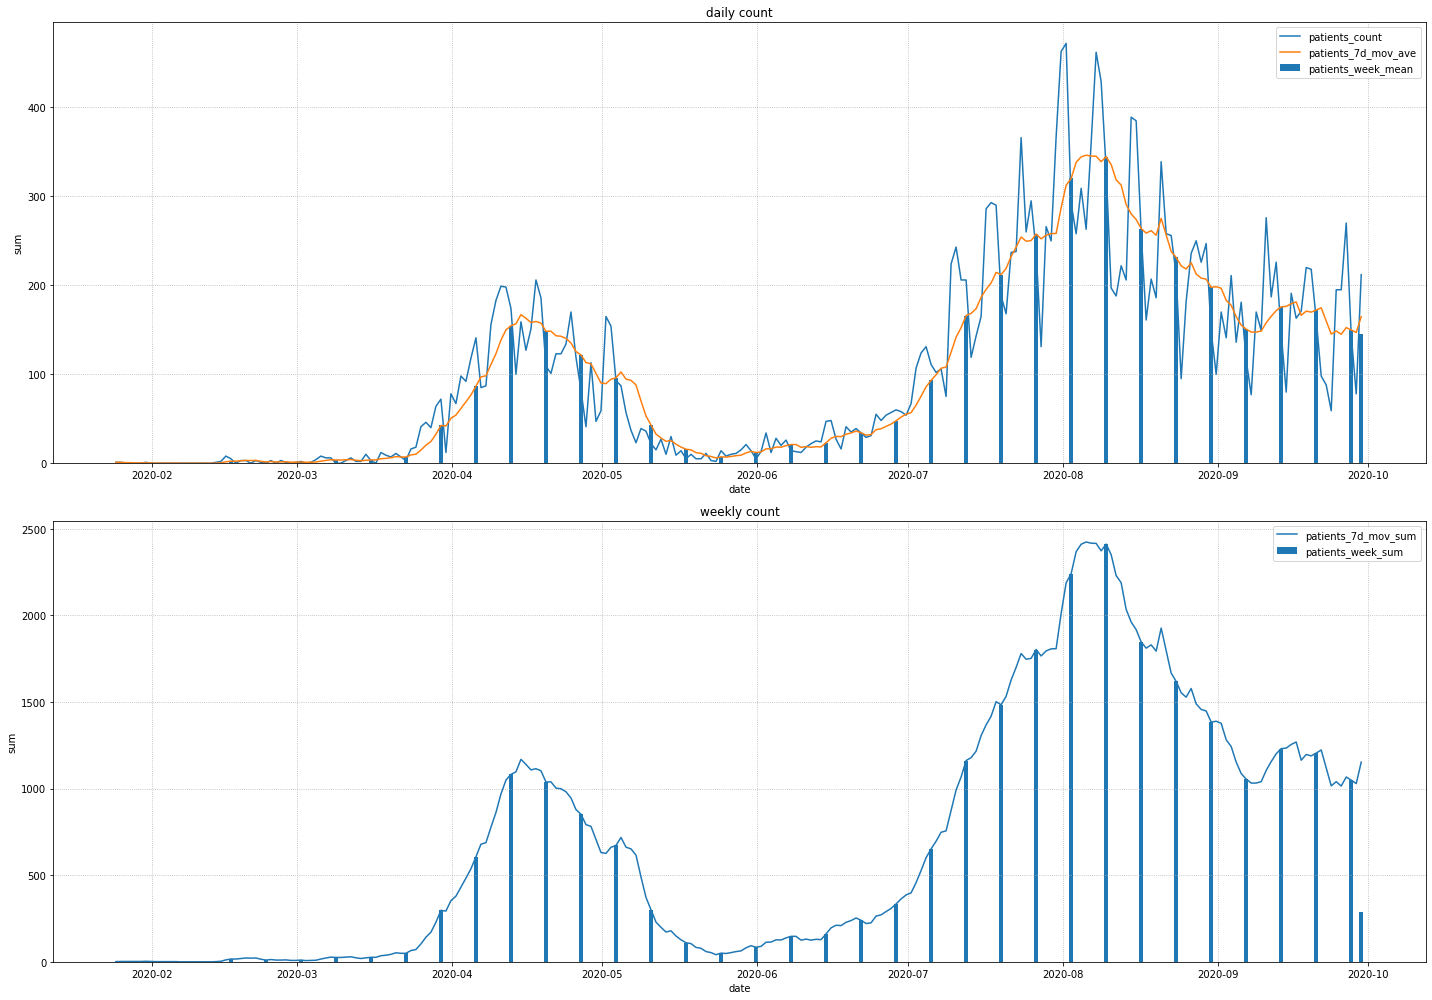

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
235,1.600157e+09,2020,9,15,0,0,0,0,0,1,0,235,0,161,528,633.571429,4435.0,1788,1767.000000,12369.0,191,179.285714,1255.0,0,0.0,0.0
236,1.600243e+09,2020,9,16,0,0,0,0,0,0,1,236,0,162,511,620.142857,4341.0,1775,1769.000000,12383.0,163,181.285714,1269.0,0,0.0,0.0
237,1.600330e+09,2020,9,17,0,0,0,0,1,0,0,237,0,163,533,610.428571,4273.0,1784,1770.857143,12396.0,171,166.285714,1164.0,0,0.0,0.0
238,1.600416e+09,2020,9,18,1,0,0,0,0,0,0,238,0,164,558,603.857143,4227.0,1845,1750.571429,12254.0,220,171.000000,1197.0,0,0.0,0.0
239,1.600502e+09,2020,9,19,0,0,1,0,0,0,0,239,0,165,609,573.142857,4012.0,1283,1725.571429,12079.0,218,169.857143,1189.0,0,0.0,0.0
240,1.600589e+09,2020,9,20,0,0,0,1,0,0,0,240,0,166,634,580.142857,4061.0,1316,1728.285714,12098.0,162,172.142857,1205.0,0,0.0,0.0
241,1.600675e+09,2020,9,21,0,1,0,0,0,0,0,241,0,167,669,577.428571,4042.0,1272,1580.428571,11063.0,98,174.714286,1223.0,0,0.0,0.0
242,1.600762e+09,2020,9,22,0,0,0,0,0,1,0,242,0,168,695,601.285714,4209.0,1215,1498.571429,10490.0,88,160.000000,1120.0,0,0.0,0.0
243,1.600848e+09,2020,9,23,0,0,0,0,0,0,1,243,0,169,580,611.142857,4278.0,2495,1601.428571,11210.0,59,145.142857,1016.0,0,0.0,0.0
244,1.600934e+09,2020,9,24,0,0,0,0,1,0,0,244,0,170,544,612.714286,4289.0,1538,1566.285714,10964.0,195,148.571429,1040.0,0,0.0,0.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              250 non-null    float64
 1   year                   250 non-null    int64  
 2   month                  250 non-null    int64  
 3   day                    250 non-null    int64  
 4   Fri                    250 non-null    uint8  
 5   Mon                    250 non-null    uint8  
 6   Sat                    250 non-null    uint8  
 7   Sun                    250 non-null    uint8  
 8   Thu                    250 non-null    uint8  
 9   Tue                    250 non-null    uint8  
 10  Wed                    250 non-null    uint8  
 11  passed                 250 non-null    int64  
 12  emergency              250 non-null    int64  
 13  em_passed              250 non-null    int64  
 14  contacts_count         250 non-null    int64  
 15  contac

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
count,2.500000e+02,250.0,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.00000,250.0,250.0,250.0
mean,1.590610e+09,2020.0,5.360000,16.016000,0.144000,0.144000,0.144000,0.144000,0.140000,0.144000,0.140000,124.500000,0.196000,61.600000,837.480000,832.629048,5828.388000,1323.40400,1309.754857,9168.284000,102.188000,100.121314,700.78400,0.0,0.0,0.0
std,6.247841e+06,0.0,2.377606,8.882982,0.351794,0.351794,0.351794,0.351794,0.347683,0.351794,0.347683,72.312977,0.397765,58.534993,504.453923,491.408926,3439.888452,813.17315,624.412000,4370.883999,108.805529,100.374528,702.68663,0.0,0.0,0.0
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0
25%,1.585231e+09,2020.0,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.250000,0.000000,0.000000,509.250000,507.571429,3553.000000,740.00000,950.750000,6655.250000,9.000000,7.571429,53.00000,0.0,0.0,0.0
50%,1.590610e+09,2020.0,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,124.500000,0.000000,50.500000,685.500000,690.928571,4836.500000,1327.50000,1288.142857,9017.000000,59.500000,67.142857,470.00000,0.0,0.0,0.0
75%,1.595988e+09,2020.0,7.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,186.750000,0.000000,112.750000,1095.750000,1098.964286,7692.750000,1841.25000,1759.107143,12313.750000,173.250000,166.821429,1167.75000,0.0,0.0,0.0
max,1.601366e+09,2020.0,9.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,249.000000,1.000000,175.000000,2265.000000,2096.857143,14678.000000,4060.00000,2574.142857,18019.000000,472.000000,346.285714,2424.00000,0.0,0.0,0.0


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
timestamp,1.000000e+00,NaN,0.992455,0.046878,-0.011367,0.005683,-0.005683,1.701697e-18,0.002795,0.011367,-0.002795,1.000000e+00,-0.181301,0.971653,0.217628,0.276991,0.276997,0.515843,0.721547,0.721547,0.668187,0.730059,0.730150,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.924548e-01,NaN,1.000000,-0.075764,-0.014212,0.004994,-0.004609,1.920579e-04,0.001943,0.009795,0.001943,9.924548e-01,-0.176826,0.961617,0.225338,0.282197,0.282203,0.520109,0.728579,0.728579,0.670446,0.730147,0.730250,NaN,NaN,NaN
day,4.687821e-02,NaN,-0.075764,1.000000,0.023678,0.005685,-0.009736,-7.402457e-04,0.007074,0.012111,-0.038438,4.687821e-02,-0.017940,0.058697,-0.042885,-0.022126,-0.022132,-0.029113,-0.051419,-0.051419,-0.026896,-0.011876,-0.011972,NaN,NaN,NaN
Fri,-1.136654e-02,NaN,-0.014212,0.023678,1.000000,-0.168224,-0.168224,-1.682243e-01,-0.165485,-0.168224,-0.165485,-1.136654e-02,-0.001607,-0.008308,-0.016775,-0.007173,-0.007172,0.067168,-0.009670,-0.009670,0.092355,-0.006200,-0.006258,NaN,NaN,NaN
Mon,5.683272e-03,NaN,0.004994,0.005685,-0.168224,1.000000,-0.168224,-1.682243e-01,-0.165485,-0.168224,-0.165485,5.683272e-03,-0.001607,0.006319,0.049056,-0.001502,-0.001500,0.278732,0.002071,0.002071,-0.144347,0.001721,0.001735,NaN,NaN,NaN
Sat,-5.683272e-03,NaN,-0.004609,-0.009736,-0.168224,-0.168224,1.000000,-1.682243e-01,-0.165485,-0.168224,-0.165485,-5.683272e-03,-0.001607,-0.003432,0.038782,-0.005139,-0.005137,-0.328276,-0.006533,-0.006533,0.106204,-0.001829,-0.001872,NaN,NaN,NaN
Sun,1.701697e-18,NaN,0.000192,-0.000740,-0.168224,-0.168224,-0.168224,1.000000e+00,-0.165485,-0.168224,-0.165485,1.121724e-18,-0.001607,0.001443,-0.014444,-0.003520,-0.003518,-0.301645,-0.003521,-0.003521,-0.025052,0.000473,0.000467,NaN,NaN,NaN
Thu,2.795367e-03,NaN,0.001943,0.007074,-0.165485,-0.165485,-0.165485,-1.654852e-01,1.000000,-0.165485,-0.162791,2.795367e-03,0.004066,-0.001184,0.000531,0.010436,0.010438,0.093181,0.009916,0.009916,0.073296,0.001944,0.001982,NaN,NaN,NaN
Tue,1.136654e-02,NaN,0.009795,0.012111,-0.168224,-0.168224,-0.168224,-1.682243e-01,-0.165485,1.000000,-0.165485,1.136654e-02,-0.001607,0.011195,-0.044837,-0.001502,-0.001500,0.103795,0.002071,0.002071,-0.037327,0.005154,0.005179,NaN,NaN,NaN


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum', 'discharges_count',
       'discharges_7d_mov_ave', 'discharges_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          'discharges_7d_mov_ave', 'discharges_7d_mov_sum'], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0,0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0,0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0,0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0,0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.601021e+09,1,0,0,0,0,0,0,245,0,171,559,1714,195,145.000000,1015.0,0
246,1.601107e+09,0,0,1,0,0,0,0,246,0,172,613,1201,270,152.428571,1067.0,0
247,1.601194e+09,0,0,0,1,0,0,0,247,0,173,488,1153,144,149.857143,1049.0,0
248,1.601280e+09,0,1,0,0,0,0,0,248,0,174,608,2141,78,147.000000,1029.0,0


In [26]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


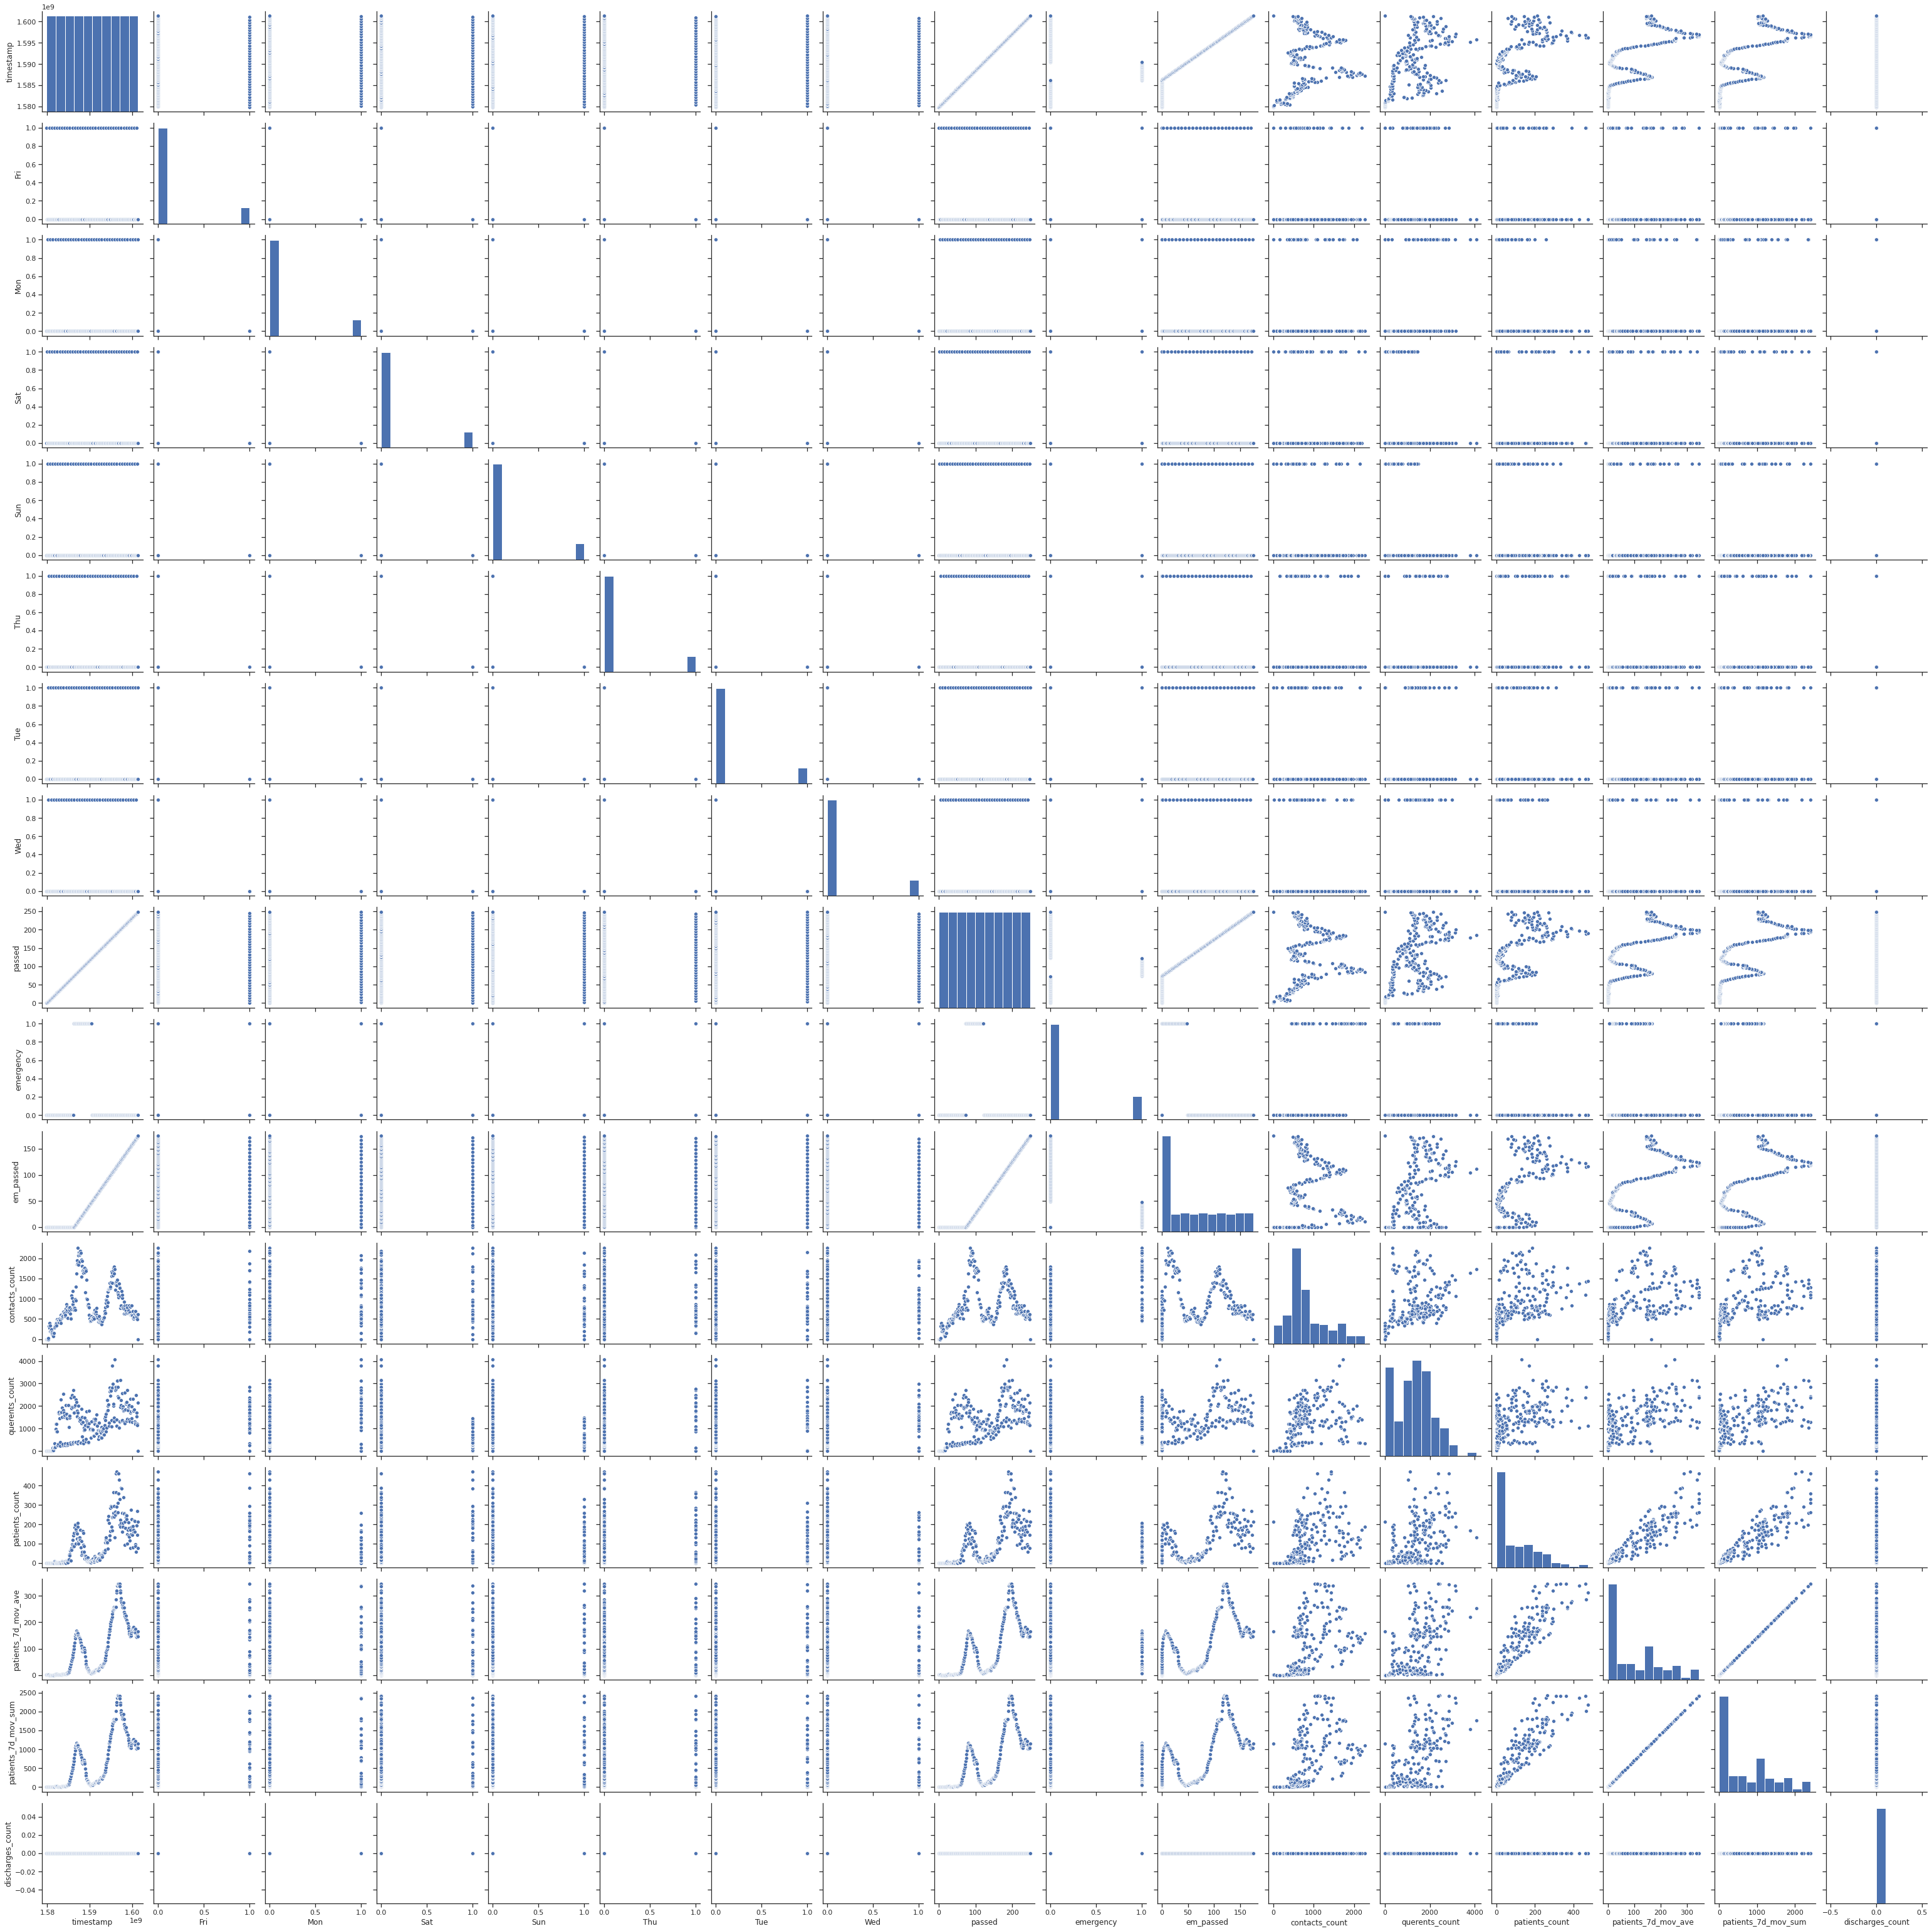

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
